In [1]:
# 여러분의 정신 건강을 위해, 그냥 프로젝트 옮길 때마다 복붙 해서 쓰는 것을 추천 드립니다.
# 한 번만 날먹 하겠습니다. 좋잖아.
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

## Fashion MNIST
우리가 오늘 해 볼 것은, **DNN을 이용한 Fashion MNIST Dataset** 분류 입니다. 여기서 말하는 **Fashion MNIST**는 입력이 28x28 크기의 행렬로 이루어져 있고 출력은 10개의 분류로 나타 냅니다. 열 개의 분류는 다음과 같습니다. (T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot)

첫 번째로, 데이터를 불러 오기 전, 데이터를 전처리 하기 위한 **파이프 라인**을 구성 해 보겠습니다. 아래 코드는 **Input Data**를 **Tensor**로 만들고, 이를 **Z-Score Normalization**을 하는 모습입니다. `transforms.Compose`를 이용하여 파이프라인을 구성하고, `transforms.ToTensor()`를 통해 `Tensor`로의 변환, `transforms.Normalize`를 통해 Z-Score Normalization을 실시 합니다.

In [2]:
RANDOM_SEED = 123
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
custom_train_transform = transforms.Compose([  
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=(0.5,), std=(0.5,))
])

custom_test_transform = transforms.Compose([
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=(0.5,), std=(0.5,))
])

두 번째로는 만들어진 **파이프라인**에, **Fashion MNIST** 데이터를 넣어 전처리를 해 보겠습니다. 이는 `Dataset`을 불러 올 때 `transform` 파라미터에 값을 넣어 줌으로써 가능 합니다.

`DataLoader`를 통해 **데이터 셋**을 **미니 배치**로 분류하고, **데이터를 섞어 줄 수** 있습니다.

In [4]:
BATCH_SIZE = 64

train_dataset = FashionMNIST(".", train=True, download=True, transform=custom_train_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          drop_last=True,
                          num_workers=2)


test_dataset = FashionMNIST(".", train=False, download=True, transform=custom_test_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=2)

/opt/anaconda3/envs/data_science/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459044803/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


아래 창은 데이터가 잘 다운로드 되었는지 확인 하는 코드입니다.

In [5]:
for batch_idx, (x, y) in enumerate(train_loader):
    print(' | Batch size:', y.size()[0])

    x = x.to(DEVICE)
    y = y.to(DEVICE)
    
    print("X shape: ", x.shape)
    print("Y shape: ", y.shape)

    print('break minibatch for-loop')
    break

 | Batch size: 64
X shape:  torch.Size([64, 1, 28, 28])
Y shape:  torch.Size([64])
break minibatch for-loop


## CNN
이제 **CNN 모델**을 구현 해 볼 시간입니다. 한 번 구현을 해 볼까요?

저번 **DNN 모델**에서 사용한 테크닉과 같습니다. 사용한 레이어만 다를 뿐이죠, `nn.Conv2d`는 **Convolution Layer**를 구현 하는데 사용 하며, `(input_channel, output_channel, filter_size)`를 입력으로 받습니다. `padding='same'`을 적용 해 주면 너비와 높이를 유지 해 줍니다.

`nn.MaxPool2d`는 **Pooling Layer**를 구현 하는데 사용하며, `(filter_size, stride)`를 입력으로 받습니다. 

In [6]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.convs = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 3)), 
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=2)
        )
        
        self.layers = nn.Sequential(
            nn.Linear(64 * 5 * 5, 512),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.Linear(256, 128),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.Linear(64, 10)
        )
    def forward(self, x):
        out = self.convs(x)
        out = out.view(-1, 64 * 5 * 5)
        logits = self.layers(out)
        probas = torch.sigmoid(logits)
        return logits, probas
    
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

model = CNN()

model = model.to(DEVICE)

## Training
Training 과정에 대한 코드는 주석으로 설명 하겠습니다.

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # 파라미터 학습을 위한 optimizer, 경사 하강법에 도움을 줌
NUM_EPOCHS = 10

def compute_accuracy_and_loss(model, data_loader, device):  # 손실 계산
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):  # 미니 배치 iteration
            
        features = features.to(device)  # view를 통해 [batch_size * 784] 크기로 변경
        targets = targets.to(device)  # 타겟

        logits, probas = model(features)  # 모델 결과 반환 (결과, sigmoid 적용한 결과)
        cross_entropy += F.cross_entropy(logits, targets).item()  # 타겟과 연산 결과의 cost function 결과
        _, predicted_labels = torch.max(probas, 1)  # 예측 결과 반환
        num_examples += targets.size(0)  # input 개수 반환
        correct_pred += (predicted_labels == targets).sum()  # 맞은 갯수 반환
    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples  # 정확도, cost function 평균
    

start_time = time.time()  # 시작 시간 계산
train_acc_lst, test_acc_lst = [], []  # 훈련 데이터 정확도, 테스트 데이터 정확도
train_loss_lst, test_loss_lst = [], []  # 훈련 데이터 손실함수, 테스트 데이터 손실함수

for epoch in range(NUM_EPOCHS):  # EPOCH 만큼 반복
    
    model.train()  # 학습 모드
    
    for batch_idx, (features, targets) in enumerate(train_loader):  # 미니 배치 iteration
    
        ### PREPARE MINIBATCH
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)  # 순전파
        cost = F.cross_entropy(logits, targets)  # 예측 결과에 대한 cost function 계산
        optimizer.zero_grad()  # 기울기 0 초기화
        
        cost.backward()  # 역전파
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()  # 모델 파라미터 업데이트
        
        ### LOGGING
        if not batch_idx % 40:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    # 매 Epoch마다 evaluation을 진행합니다. 
    # Epoch마다 Loss를 기록하여 학습과정을 살펴보고 Underfitting, Overfitting 여부를 확인합니다.
    model.eval()
    with torch.set_grad_enabled(False): # Gradient 계산이 안되도록
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=DEVICE) # train acc, loss 계산
        test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, device=DEVICE)    # test acc, loss 계산
        
        # list에 train, test의  acc, loss 추가
        train_acc_lst.append(train_acc)
        test_acc_lst.append(test_acc)
        train_loss_lst.append(train_loss)
        test_loss_lst.append(test_loss)
        
        # 로깅
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Test Acc.: {test_acc:.2f}%')
    
    # 1 epoch 학습 소요시간
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')

# 총 학습 소요시간
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/010 | Batch 000/937 | Cost: 2.3602
Epoch: 001/010 | Batch 040/937 | Cost: 0.6271
Epoch: 001/010 | Batch 080/937 | Cost: 0.7231
Epoch: 001/010 | Batch 120/937 | Cost: 0.5417
Epoch: 001/010 | Batch 160/937 | Cost: 0.5460
Epoch: 001/010 | Batch 200/937 | Cost: 0.4734
Epoch: 001/010 | Batch 240/937 | Cost: 0.3435
Epoch: 001/010 | Batch 280/937 | Cost: 0.4397
Epoch: 001/010 | Batch 320/937 | Cost: 0.4576
Epoch: 001/010 | Batch 360/937 | Cost: 0.3435
Epoch: 001/010 | Batch 400/937 | Cost: 0.3735
Epoch: 001/010 | Batch 440/937 | Cost: 0.1810
Epoch: 001/010 | Batch 480/937 | Cost: 0.1932
Epoch: 001/010 | Batch 520/937 | Cost: 0.3519
Epoch: 001/010 | Batch 560/937 | Cost: 0.5424
Epoch: 001/010 | Batch 600/937 | Cost: 0.3839
Epoch: 001/010 | Batch 640/937 | Cost: 0.5460
Epoch: 001/010 | Batch 680/937 | Cost: 0.2163
Epoch: 001/010 | Batch 720/937 | Cost: 0.4857
Epoch: 001/010 | Batch 760/937 | Cost: 0.5878
Epoch: 001/010 | Batch 800/937 | Cost: 0.4491
Epoch: 001/010 | Batch 840/937 | C

Epoch: 008/010 | Batch 000/937 | Cost: 0.1948
Epoch: 008/010 | Batch 040/937 | Cost: 0.2406
Epoch: 008/010 | Batch 080/937 | Cost: 0.1953
Epoch: 008/010 | Batch 120/937 | Cost: 0.3369
Epoch: 008/010 | Batch 160/937 | Cost: 0.3353
Epoch: 008/010 | Batch 200/937 | Cost: 0.2103
Epoch: 008/010 | Batch 240/937 | Cost: 0.2737
Epoch: 008/010 | Batch 280/937 | Cost: 0.2138
Epoch: 008/010 | Batch 320/937 | Cost: 0.0896
Epoch: 008/010 | Batch 360/937 | Cost: 0.1376
Epoch: 008/010 | Batch 400/937 | Cost: 0.1642
Epoch: 008/010 | Batch 440/937 | Cost: 0.1159
Epoch: 008/010 | Batch 480/937 | Cost: 0.6495
Epoch: 008/010 | Batch 520/937 | Cost: 0.3234
Epoch: 008/010 | Batch 560/937 | Cost: 0.1241
Epoch: 008/010 | Batch 600/937 | Cost: 0.3427
Epoch: 008/010 | Batch 640/937 | Cost: 0.0734
Epoch: 008/010 | Batch 680/937 | Cost: 0.2052
Epoch: 008/010 | Batch 720/937 | Cost: 0.1973
Epoch: 008/010 | Batch 760/937 | Cost: 0.2400
Epoch: 008/010 | Batch 800/937 | Cost: 0.1823
Epoch: 008/010 | Batch 840/937 | C

## Evaluation
테스트 데이터와 학습 데이터의 Loss변화를 확인합니다.

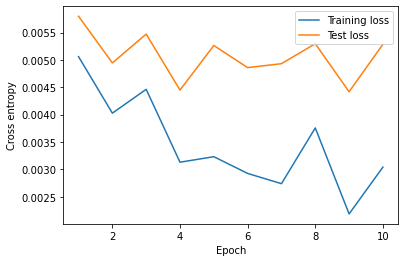

In [8]:
plt.plot(range(1, NUM_EPOCHS+1), train_loss_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), test_loss_lst, label='Test loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

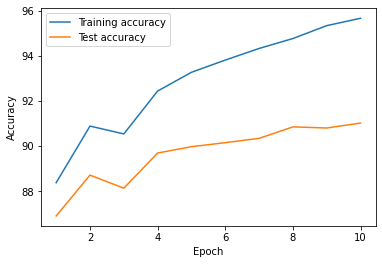

In [9]:
plt.plot(range(1, NUM_EPOCHS+1), train_acc_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), test_acc_lst, label='Test accuracy')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [10]:
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 91.03%
